# Line-of-sight shear in SLACS strong lenses II
_Natalie B. Hogg, Daniel Johnson, Anowar J. Shajib, and Julien Larena (2025)_
arXiv: 2512.xxxx

This notebook allows you to reproduce the figures shown in the above paper, as well as the statistical tests described in Section 3.2. It assumes you are working in a Python environment with the packages listed in the following cells installed, and that you have downloaded the necessary data files from the following Zenodo repository: https://zenodo.org/records/17816315. You then just need to provide the path to where you downloaded the data:

In [1]:
path = r'/home/nataliehogg/Documents/Projects/slacs/zenodo/'

### Import packages

In [2]:
# reading files
import os
import sys
import glob
import h5py
import pickle
import yaml
import pandas as pd

In [3]:
# computations
import numpy as np
from scipy import stats
import astropy.coordinates as coord
import astropy.units as u

In [4]:
# plots, colours and style
from matplotlib import rc, offsetbox, colors, cm, patches, pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler

import cmasher as cmr
import cmocean as cmo

# apply sanglier style
plt.rcParams.update({
  'lines.linewidth': 3.0,
  'font.family': 'serif',
  'font.size': 14,
  'text.usetex': True,
  'axes.prop_cycle': cycler('color', ['#a0c3db', '#dbb7a0', '#c2a5cf', '#a6dba0'])
})

# neat colourbar handler
def colorbar(mappable, lab, padding, fontsize, **kwargs):
    # thanks to Joseph Long! https://joseph-long.com/writing/colorbars/
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '2.5%', pad = padding)
    cbar = fig.colorbar(mappable, cax = cax, **kwargs)
    cbar.set_label(lab, size=fontsize)
    cbar.ax.tick_params(labelsize=fontsize) 
    plt.sca(last_axes)
    return cbar

# get provided implementation of cubehelix colourmap so that we can manipulate the colours
sys.path.insert(0, path)
import cubehelix

cmap_cubehelix = cubehelix.cmap(reverse=False, start=0.5, rot=-0.5, gamma=1.0, sat=1.0) # hue in original cubehelix docs is called sat here

cmap_cubehelix_red = cubehelix.cmap(reverse=False, start=0, rot=0.5, gamma=1.0, sat=1.0)

In [5]:
# stop Juypter complaining about a divide by zero in lenstronomy
import warnings
warnings.filterwarnings('ignore')

### Read in data

In [6]:
# external shear measurements from Shajib et al. (2021), Tan et al. (2024), Etherington et al. (2024)
literature_df = pd.read_csv(path+'anowar_chinyi_amy_shears.csv')

In [7]:
# minimal model results; read in paper I for later comparisons
min_df_paperI = pd.read_csv(path+'MIN_shear_and_redshifts_paper_I.csv')
min_df = pd.read_csv(path+'MIN_shear_and_redshifts_paper_II.csv')

In [8]:
# boxy/disky model results
bodi_df = pd.read_csv(path+'BODI_shear_and_redshifts_paper_II.csv')

In [9]:
# shears from N-body simulations
# we only have them computed for the paper I (zd, zs) pairs, but the redshift distributions are sufficiently similar
# that we can re-use them here
sampled_los_effects = []
for i, name in enumerate(min_df_paperI['Name']):
    filename = path+f'RayGalGroupSims_for_slacs/{name}'
    with open(filename, 'rb') as f:
        sampled_los_effects.append(pickle.load(f))        

### Figures 1, 2, 3, and 4

⚠️ These figures rely on the following versions of `dolphin` and `ChainConsumer`:
- [dolphin](https://github.com/nataliehogg/dolphin); branch `master`, commit `73e244e` for absolute reproducibility.
- [ChainConsumer](https://github.com/Samreay/ChainConsumer); branch `master`, commit `234d840` for absolute reproducibility.

To run the cell below, clone the above-linked repositories, navigate to the relevant directories and run `$ pip install -e .` 

Another word of caution: all figures showing posteriors in the paper were generated in the following way: 
1) chain extracted from the `dolphin` output object and saved in `.h5` file
2) `.h5` file loaded into plotting script as a DataFrame and burn-in removed
3) figures produced

To avoid uploading both the chains and output files to Zenodo, in this notebook we show how to plot by directly extracting the chain from the dolphin output object. In practice (and for an untraceable reason), this introduces some very small numerical discrepancies in the best-fit values quoted for some parameters.

In [10]:
# import dolphin
from dolphin.analysis.output import Output

# import chainconsumer
from chainconsumer import Chain, ChainConsumer, PlotConfig
from chainconsumer.plotting import plot_dist
c = ChainConsumer()

In [11]:
def lims_getter_1d(chain, px, nsig=5):
    '''
    gets x limits for the 1D distribution plot based on the parameter summary
    '''
    from chainconsumer.analysis import Analysis

    analysis = Analysis(None)
    param_summary = analysis.get_parameter_summary(chain, px)

    if param_summary is not None and param_summary.lower is not None and param_summary.upper is not None:
        # Use the parameter summary to get the range
        lower = param_summary.lower
        upper = param_summary.upper
        center = param_summary.center

        # Extend by nsig times the standard deviation
        std = max(center - lower, upper - center)
        x_lower = center - nsig * std
        x_upper = center + nsig * std

        return x_lower, x_upper
    else:
        # Fallback: use data percentiles
        data = chain.get_data(px)
        lower_percentile = np.percentile(data, 0.1)
        upper_percentile = np.percentile(data, 99.9)
        return lower_percentile, upper_percentile

Here we set the model ID. There are four options: 
- `full`, the baseline EPL + minimal LOS model
- `godf`, or "gamma_od fixed", the baseline EPL + minimal LOS model with $\gamma_{\rm od}=0$
- `wlos`, the baseline EPL + minimal LOs model with $\gamma_{\rm od} = \omega_{\rm LOS} = 0$
- `bodi`, the baseline _boxy/disky_ EPL + minimal LOS model. 

Figures 1-4 in the paper show the `full` model results.

In [12]:
model_id = 'full'

In [13]:
params = [r'$\gamma_{\rm lens}$', r'$e_{1, \rm lens}$', r'$e_{2, \rm lens}$', r'$x_{\rm lens}$', r'$y_{\rm lens}$',
          r'$\gamma^{\rm od}_1$', r'$\gamma^{\rm od}_2$', r'$\gamma^{\rm LOS}_1$', r'$\gamma^{\rm LOS}_2$', r'$\omega^{\rm LOS}$', 
          r'$\beta$', r'$x_{\rm s}$', '$y_{\rm s}$', r'$R_{\rm Sersic, s}$', r'$n_{\rm Sersic, s}$', r'$e_1^{\rm s}$', r'$e_2^{\rm s}$',
          r'$R_{\rm Sersic, ll1}$', r'$e_1^{\rm ll1}$', r'$e_2^{\rm ll1}$', r'$x_{\rm ll}$', r'$y_{\rm ll}$', 
          r'$R_{\rm Sersic, l2}$',r'$e_1^{\rm ll2}$',r'$e_2^{\rm ll2}$',]

SDSSJ0008-0004
-1.0011091814717425 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0011091814717403


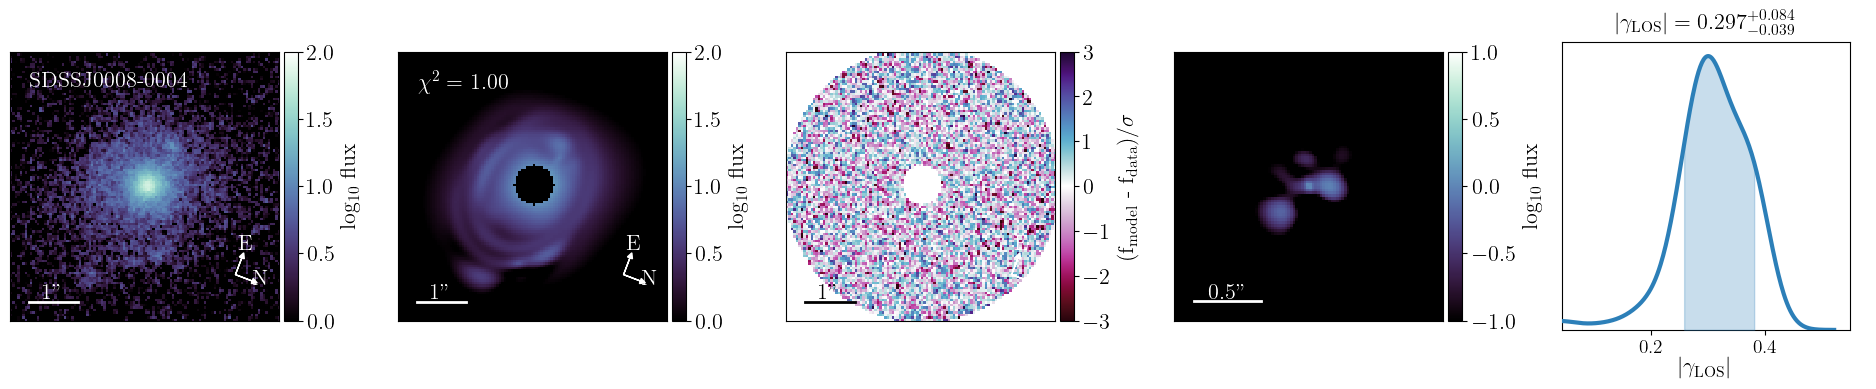

In [14]:
lens_df = pd.read_csv(path+'lens_database.csv')

output = Output(path+'lens_modelling_results/')

# paperI_indices = [1,2,4,5,6,7,9,13,19,24,27,28,29,31,34,37,38,39,40,42,43,45,48]

paperII_indices = [0,3,8,10,11,12,14,15,16,17,18,20,21,23,25,26,30,33,35,36,41,44,46,47,49]

lens_index = 0

try:
    # get meta-data related to name, colourbars, burnin etc
    lens_name = lens_df.iloc[lens_index]['Name']
    print(lens_name)
    lens_filter = lens_df.iloc[lens_index]['Filter']
    v_min = lens_df.iloc[lens_index]['vmin']
    v_max = lens_df.iloc[lens_index]['vmax']
    source_vmin = lens_df.iloc[lens_index]['source_vmin']
    source_vmax = lens_df.iloc[lens_index]['source_vmax']
    burnin = int(lens_df.iloc[lens_index]['burnin'])
    nsig = float(lens_df.iloc[lens_index]['nsig'])

    # load the mask
    mask_path = path+'/masks/'+lens_name+'_'+lens_filter+'_mask.txt'

    # load the output
    output.load_output(lens_name=lens_name, model_id=model_id, mask_path=mask_path)

    # get the kwargs_result
    kwargs_result = output.kwargs_result

    # get the lenstronomy ModelPlot
    ModelPlot, vmax, chi2 = output.get_model_plot(lens_name=lens_name, model_id=model_id,
                                                  mask_path=mask_path, kwargs_result=kwargs_result,
                                                  band_index=0, 
                                                  data_cmap = cmap_cubehelix)

    # read in the chain
    chain_dolphin = output.samples_mcmc

    chain_unburned = pd.DataFrame.from_dict({par: val for par, val in zip(params, chain_dolphin.T)})
    
    # remove burnin
    chain = chain_unburned[burnin:]

    # get the g1 and g2 samples
    g1_los_samples = chain[r'$\gamma^{\rm LOS}_1$']
    g2_los_samples = chain[r'$\gamma^{\rm LOS}_2$']

    # combine g1 and g2 to get |gamma_LOS| samples
    gamma_los_samples = np.sqrt(g1_los_samples[burnin:]**2. + g2_los_samples[burnin:]**2.)

    # put them in a dataframe for chainconsumer
    glos_df = pd.DataFrame(gamma_los_samples, columns=[r'|\gamma_{\rm LOS}|'])

    # set up plot
    fig = plt.figure(figsize=(20,4))
    
    global_fontsize=16
    
    # use a mosaic for simplicity
    ax_dict = fig.subplot_mosaic([["data", "recon", "resid", "source", "contour"],],)

    # add elements

    # the data
    ModelPlot.data_plot(band_index=0, ax=ax_dict['data'], text='', v_min=v_min, v_max=v_max, font_size=global_fontsize)

    # the model
    ModelPlot.model_plot(band_index=0, ax=ax_dict['recon'], text='', v_min=v_min, v_max=v_max, font_size=global_fontsize)

    # the residuals
    ModelPlot.normalized_residual_plot(band_index=0, ax=ax_dict['resid'], 
                                       cmap=cmr.viola_r,
                                       text='', v_min=-3, v_max=3, font_size=global_fontsize)

    # the source
    ModelPlot.source_plot(band_index=0, ax=ax_dict['source'], deltaPix_source=0.02, numPix=100, text='', 
                          v_min=source_vmin, v_max=source_vmax, scale_size=0.5, font_size=global_fontsize)

    # configure chainconsumer
    c.set_plot_config(PlotConfig(serif=True, usetex=True, summarise=True, label_font_size=global_fontsize, 
                                 tick_font_size=global_fontsize, 
                                 summary_font_size=global_fontsize, max_ticks = 4, spacing=2.0))

    # create the Chain object
    chain_object = Chain(samples=glos_df, name=lens_name, shade=True, 
                                           color='#2c7fb8', 
                                           smooth=20, bins=10,
                                           shade_gradient = 0.4, linewidth=3.0)

    # plot the 1D |gamma_LOS| distribution
    plot_dist(ax_dict['contour'], chain_object, config=c.plotter.config, px=r"|\gamma_{\rm LOS}|", summary=True)

    # get the x-axis limits adapted to this distribution
    xmin, xmax = lims_getter_1d(chain_object, r"|\gamma_{\rm LOS}|", nsig=3)

    # titles, axis labels and axis text
    ax_dict['data'].add_artist(offsetbox.AnchoredText(lens_name, 
                                                      loc='upper left', frameon=False, 
                                                      prop = {'fontsize':global_fontsize, 'color':'white'}))

    ax_dict['recon'].add_artist(offsetbox.AnchoredText(r'$\chi^2 = $ {:.2f}'.format(chi2), 
                                                       loc='upper left', frameon=False, 
                                                       prop = {'fontsize':global_fontsize, 'color':'white'}))

    ax_dict['contour'].set_yticks([])
    ax_dict['contour'].set_xlim(xmin, xmax)
    ax_dict['contour'].set_ylim(bottom=0)
    ax_dict['contour'].set_xlabel(r'$|\gamma_{\rm LOS}|$', fontsize=global_fontsize, labelpad=0)
    ax_dict['contour'].axes.set_box_aspect(1)

    fig.subplots_adjust(left=0.01, right=0.93, top=0.98, bottom=0.12, wspace=0.35) 
    
    plt.show()

except FileNotFoundError:
    pass

### Figure 5

This figure shows the lenses for which we consider the modelling to be a failure i.e.:
- SDSSJ1143$-$0144 (lens index `22`)
- SDSSJ1213$+$6708 (lens index `25`)
- SDSSJ1403$+$0006 (lens index `32`)
- SDSSJ1538$+$5817 (lens index `35`)
- SDSS2347$-$0005 (lens index `49`)

SDSSJ1143-0144
-0.529766547123317 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.5297665471749297
SDSSJ1213+6708
-0.8916570753911899 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8916570753948205
SDSSJ1403+0006
-0.6933906460229161 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.6933906460188801
SDSSJ1538+5817
-0.9209495290577971 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9209495290993345
SDSSJ2347-0005
-1.0348983674141443 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0348983674138836


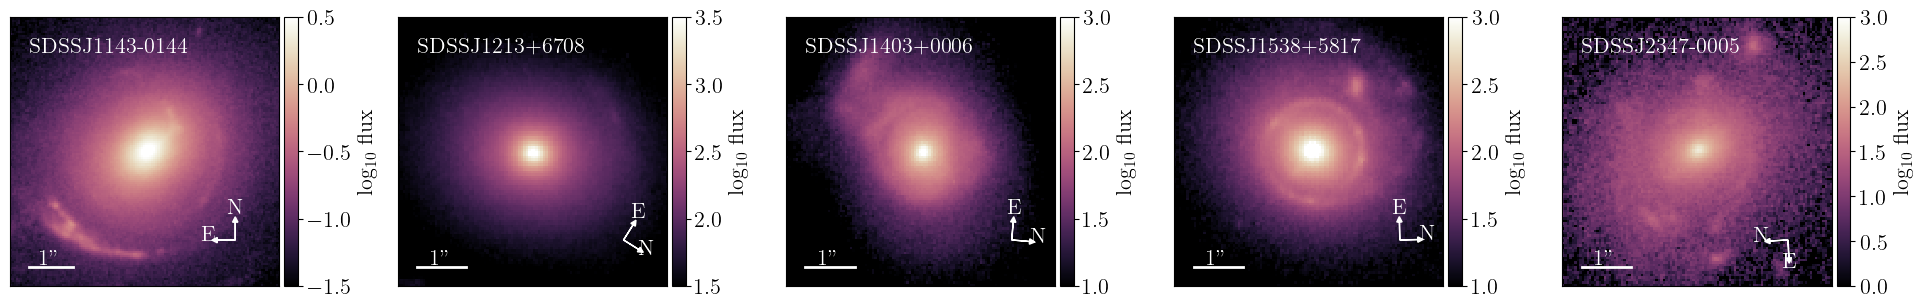

In [15]:
c = ChainConsumer()

output = Output(path+'lens_modelling_results/')

indices = [22, 25, 32, 35, 49]

model_plot_list = []
vmax_list = []
vmin_list = []
names = []

for lens_index in indices:

# load the outputs
    lens_name = lens_df.iloc[lens_index]['Name']
    lens_filter = lens_df.iloc[lens_index]['Filter']
    print(lens_name)
    names.append(lens_name)
    v_min       = lens_df['vmin'][lens_index] 
    v_max       = lens_df['vmax'][lens_index] 
    vmin_list.append(v_min)
    vmax_list.append(v_max)

    mask_path = path+'/masks/'+lens_name+'_'+lens_filter+'_mask.txt'

    output.load_output(lens_name=lens_name, model_id='full', mask_path=mask_path)

    kwargs_result_full = output.kwargs_result

    ModelPlot_full, vmax_full, chi2_full = output.get_model_plot(lens_name=lens_name, model_id='full',
                                                                mask_path=mask_path, kwargs_result=kwargs_result_full,
                                                                band_index=0, 
                                                                data_cmap = cmap_cubehelix_red)

    model_plot_list.append(ModelPlot_full)

# set up plot
fig = plt.figure(figsize=(20,4))

ax_dict = fig.subplot_mosaic(
    [
        ["data1", 'data2', 'data3', 'data4', 'data5'],
    ],
)

global_fontsize=16

# add elements
model_plot_list[0].data_plot(band_index=0, ax=ax_dict['data1'], text='', v_min=vmin_list[0], v_max=vmax_list[0], font_size=global_fontsize)
model_plot_list[1].data_plot(band_index=0, ax=ax_dict['data2'], text='', v_min=vmin_list[1], v_max=vmax_list[1], font_size=global_fontsize)
model_plot_list[2].data_plot(band_index=0, ax=ax_dict['data3'], text='', v_min=vmin_list[2], v_max=vmax_list[2], font_size=global_fontsize)
model_plot_list[3].data_plot(band_index=0, ax=ax_dict['data4'], text='', v_min=vmin_list[3], v_max=vmax_list[3], font_size=global_fontsize)
model_plot_list[4].data_plot(band_index=0, ax=ax_dict['data5'], text='', v_min=vmin_list[4], v_max=vmax_list[4], font_size=global_fontsize)


# titles and axis labels
ax_dict['data1'].add_artist(offsetbox.AnchoredText(names[0], loc='upper left', frameon=False, prop = {'fontsize':global_fontsize, 'color':'white'}))
ax_dict['data2'].add_artist(offsetbox.AnchoredText(names[1], loc='upper left', frameon=False, prop = {'fontsize':global_fontsize, 'color':'white'}))
ax_dict['data3'].add_artist(offsetbox.AnchoredText(names[2], loc='upper left', frameon=False, prop = {'fontsize':global_fontsize, 'color':'white'}))
ax_dict['data4'].add_artist(offsetbox.AnchoredText(names[3], loc='upper left', frameon=False, prop = {'fontsize':global_fontsize, 'color':'white'}))
ax_dict['data5'].add_artist(offsetbox.AnchoredText(names[4], loc='upper left', frameon=False, prop = {'fontsize':global_fontsize, 'color':'white'}))

fig.subplots_adjust(left=0.01, right=0.93, top=0.98, bottom=0.12, wspace=0.35) 

plt.show()

### Figure 6

In [16]:
# we remove those lenses which have gamma_los measurements but other issues with the lens model
# as well as lenses without a gamma_los measurement
mask = ~min_df['Name'].str.contains('1538|2347|1143|1213|1403')
min_df_filtered = min_df[mask]

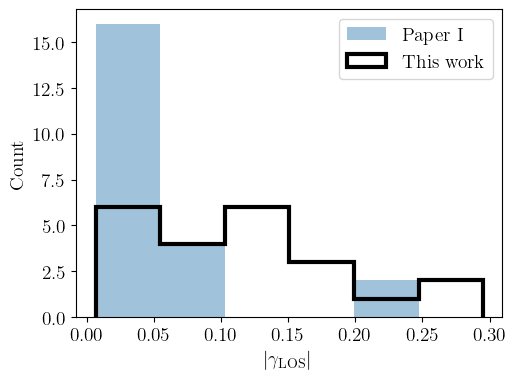

In [17]:
counts, bins = np.histogram(min_df_filtered['gamma_los'], bins=6)

fig, ax = plt.subplots(1,1, figsize=(5.5,4))

ax.hist(min_df_paperI['gamma_los'], bins=bins, label='Paper I', density=False)
ax.hist(min_df_filtered['gamma_los'], bins=bins, histtype='step', color='k', lw=3, label='This work', density=False)

ax.set_xlabel(r'$|\gamma_{\rm LOS}|$')
ax.set_ylabel('Count')
ax.legend()

plt.show()

### Figure 7

For this figure, we use the LOS shear values computed by ray-tracing through the RayGalGroup simulations (RGGS; [Rasera et al. 2021](www.arxiv.org/abs/2111.08745)). We have both the median and uncertainties for a lens and source redshift matching each in our sample (which shows the redshift-dependent trend), or the overall median and uncertainties averaged over the sample.  See [Johnson et al. 2025](https://arxiv.org/abs/2501.17153) for more information on this computation.

The figure shows how the tension metric changes when the same lenses are modelled with the addition of the octupole distortion in the mass profile. First we have to load in the LOS shear measurements from this model, then we compute the tension. Note that we use the "overall" summary statistics from the N-body simulations in this plot, rather than the ($z_{\rm d}$, $z_{\rm s}$) pairs.

⚠️ We provide the distributions of $|\gamma_{\rm LOS}|$ which were derived from the publically available RGGS maps; our code to compute these distributions from the maps is included in the repository under `extracting_lines_of_sight.py`.

In [18]:
#a single list holding all sampled shear values
all_shear_mags = [d['shear_mag_LOS'] for lens_list in sampled_los_effects for d in lens_list]

overall_summary_stats = {}

# 1, 3 and 5 sigma regions
mean = np.mean(all_shear_mags)
lower_1sigma, upper_1sigma = np.percentile(all_shear_mags, [16, 84])
lower_3sigma, upper_3sigma = np.percentile(all_shear_mags, [0.265, 99.735])
lower_5sigma, upper_5sigma = np.percentile(all_shear_mags, [100-99.9999426696856, 99.9999426696856])

# Storing results
overall_summary_stats = {
    "mean": mean,
    "lower_1sigma": lower_1sigma,
    "upper_1sigma": upper_1sigma,
    'lower_3sigma': lower_3sigma,
    'upper_3sigma': upper_3sigma,
    'lower_5sigma': lower_5sigma,
    'upper_5sigma': upper_5sigma
}

#### Compute Tension statistic

Here we compute the tension between the measurement and simulation, defined as
$$
    T_{ab} = \frac{|x_a - x_b|}{\sqrt{\rule{0pt}{2ex}\sigma_a^2 + \sigma_b^2}}.
$$

In [19]:
def Tension(lens_index, measurement, simulation, version='overall'):
    '''
    computes tension between measured gamma_LOS and expectation from simulation
    '''
    if version == 'overall':
        median = simulation['mean']
        u1 = simulation['upper_1sigma']
    elif version == 'zdzs':
        median = simulation[lens_index]['mean']
        u1 = simulation[lens_index]['upper_1sigma']
    else:
        return 'Wrong version type!'
    
    numerator = np.linalg.norm(measurement['gamma_los'].values[lens_index] - median)
    denominator = np.sqrt(measurement['gamma_lower'].values[lens_index]**2. + u1**2.)
    result = numerator/denominator
    return result

In [20]:
# lenses to be included in the figure
names = ['SDSSJ0912+0029', 'SDSSJ0959+4416', 'SDSSJ1020+1122', 'SDSSJ1023+4230',
         'SDSSJ1100+5329',  'SDSSJ1218+0830', 'SDSSJ2302-0840', 'SDSSJ2341+0000']

In [21]:
selected_min = min_df[min_df['Name'].isin(names)]
selected_bodi = bodi_df[bodi_df['Name'].isin(names)]

In [22]:
selected_tensions = [Tension(i, selected_min, overall_summary_stats, version='overall') for i in range(len(selected_min['Name']))]
selected_tensions_bodi = [Tension(i, selected_bodi, overall_summary_stats, version='overall') for i in range(len(selected_bodi['Name']))]

In [23]:
selected_delta_tensions = np.array(selected_tensions_bodi) - np.array(selected_tensions)

#### Make the plot

In [24]:
bump_font = 20 # boost the fontsize

In [25]:
cmap_delta = cmr.prinsenvlag_r
vmax_d = 4
vmin_d = -vmax_d # ensure diverging colourbar is centred at zero

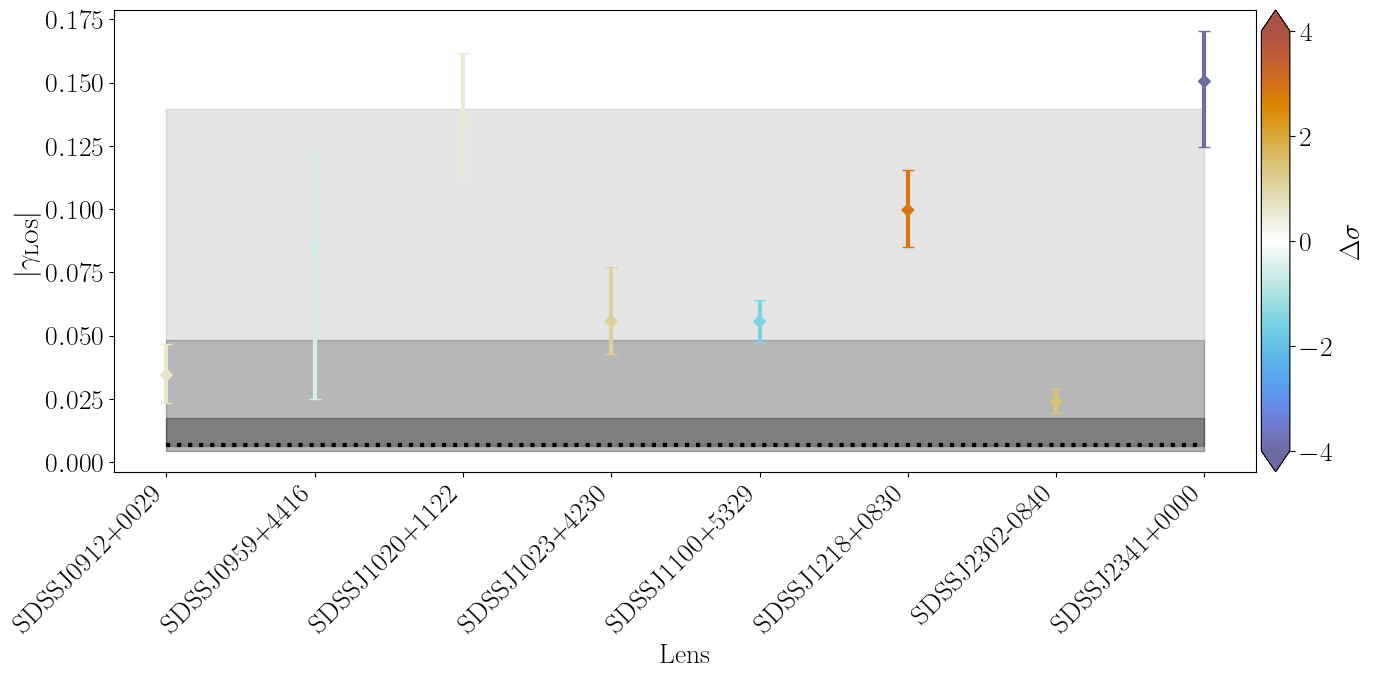

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

ax.hlines(overall_summary_stats['mean'], xmin=0, xmax=7, ls=':', color='k')

ax.fill_between(selected_min['Name'], overall_summary_stats['mean'] - overall_summary_stats['lower_1sigma'],
                overall_summary_stats['mean'] + overall_summary_stats['upper_1sigma'], 
                color='k', alpha=0.3)

ax.fill_between(selected_min['Name'], overall_summary_stats['mean'] - overall_summary_stats['lower_3sigma'],
                overall_summary_stats['mean'] + overall_summary_stats['upper_3sigma'], 
                color='k', alpha=0.2)

ax.fill_between(selected_min['Name'], overall_summary_stats['mean'] - overall_summary_stats['lower_5sigma'],
                overall_summary_stats['mean'] + overall_summary_stats['upper_5sigma'], 
                color='k', alpha=0.1)

D = ax.scatter(selected_bodi['Name'], selected_bodi['gamma_los'], 
               c=selected_delta_tensions, marker='D', vmin=vmin_d, vmax=vmax_d, cmap=cmap_delta)

colorbar(D, r'$\Delta \sigma$', padding=0.05, extend='both', fontsize=bump_font)

# now get the cbar colours for the error bars
norm_D = colors.Normalize(vmin=vmin_d, vmax=vmax_d)
mapper_D = cm.ScalarMappable(norm=norm_D, cmap=cmap_delta)
colour_D = np.array([(mapper_D.to_rgba(d)) for d in selected_delta_tensions])

# loop over each point to get the right colour for each error bar
for x, y, lerr, uerr, color in zip(selected_bodi['Name'], selected_bodi['gamma_los'], 
                                   selected_bodi['gamma_lower'], selected_bodi['gamma_upper'], colour_D):
    ax.errorbar(x, y, yerr=[[lerr], [uerr]], color=color, capsize=4)
ax.tick_params(axis='both', which='major', labelsize=bump_font)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel(r'Lens', fontsize=bump_font)
ax.set_ylabel(r'$|\gamma_{\rm LOS}|$', fontsize=bump_font)

plt.tight_layout()

plt.show()

### Figure 8

In [27]:
# get examples of the F555W and F606W PSFs
with h5py.File(path+'lens_modelling_results/data/SDSSJ0737+3216/psf_SDSSJ0737+3216_F555W.h5', 'r') as f:
    dataset = next(iter(f.keys()))
    psf_F555W = f[dataset][()]
    norm_psf_F555W = psf_F555W/psf_F555W.max()

with h5py.File(path+'lens_modelling_results/data/SDSSJ0008-0004/psf_SDSSJ0008-0004_F606W.h5', 'r') as f:
    dataset = next(iter(f.keys()))
    psf_F606W = f[dataset][()]
    norm_psf_F606W = psf_F606W/psf_F606W.max()

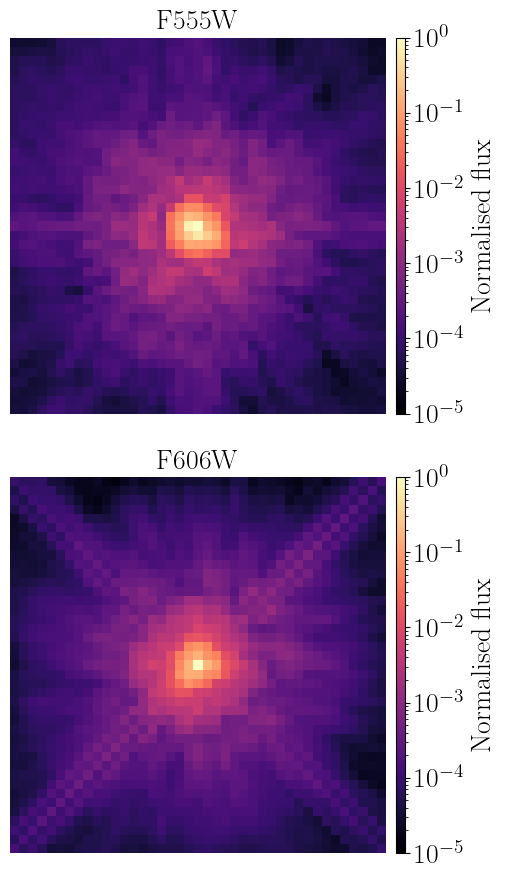

In [28]:
norm = colors.LogNorm(vmin=1e-5, vmax=1.0)

fig, ax = plt.subplots(2,1, figsize=(7, 9))

im1 = ax[0].imshow(norm_psf_F555W, origin='lower', cmap='magma', norm=norm)
im2 = ax[1].imshow(norm_psf_F606W, origin='lower', cmap='magma', norm=norm)

ax[0].set_title('F555W', fontsize=bump_font)
ax[1].set_title('F606W', fontsize=bump_font)

for a in ax.flat:
    a.axis('off')
    a.set_aspect('equal')

colorbar(im1, lab='Normalised flux', padding=0.1, fontsize=bump_font)
colorbar(im2, lab='Normalised flux', padding=0.1, fontsize=bump_font)

plt.tight_layout()

plt.show()

### Figure 9

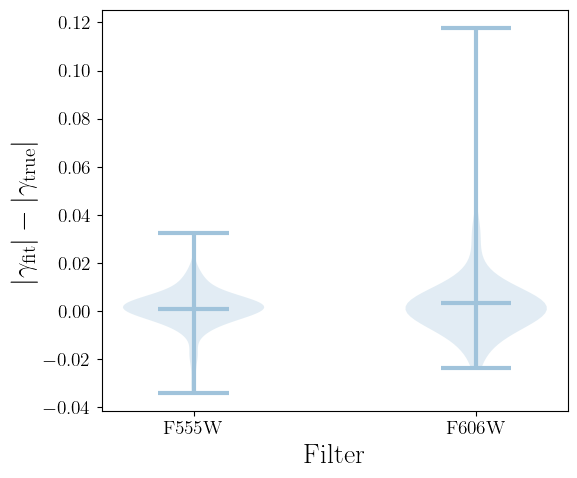

In [29]:
psf_simulations = pd.read_csv(path+'psf_results_combined.csv')

fig, ax = plt.subplots(1,1, figsize=(6,5))
filters = ['F555W', 'F606W']

values = [psf_simulations[psf_simulations['filter'] == filt]['shear_mag_resid'].dropna().values for filt in filters]
ax.violinplot(values, showmeans=True)
ax.set_xticks([1, 2])
ax.set_xticklabels(filters)

ax.set_xlabel('Filter', fontsize=bump_font)
ax.set_ylabel(r'$|\gamma_{\rm fit}| - |\gamma_{\rm true}|$', fontsize=bump_font)

plt.tight_layout()

plt.show()

### Investigation of potential correlations between image features and shear magnitude

In [30]:
# first let's merge the two databases of results (with problematic lenses removed) and compute the median shear

df_combined = pd.concat([min_df_paperI, min_df_filtered], ignore_index=True)

gamma_los_combined = df_combined['gamma_los'].to_numpy()

median_gamma_los = np.median(gamma_los_combined)

In [31]:
# split into large (>= median) and small shear (< median) groups

large_shear_df = df_combined[df_combined['gamma_los'] >= median_gamma_los]

small_shear_df = df_combined[df_combined['gamma_los'] < median_gamma_los]

#### Redshift distributions

Here we perform the two-sample Kolmogorov--Smirnov (KS) test on the redshift samples, with the null hypothesis that the two samples are drawn from the same underlying distribution.

In [32]:
ks_zl = stats.ks_2samp(small_shear_df['z_l'], large_shear_df['z_l'])
ks_zs = stats.ks_2samp(small_shear_df['z_s'], large_shear_df['z_s'])

print('Lens redshift KS test: p = {:.2f}'.format(ks_zl.pvalue))
if ks_zl.pvalue < 0.05:
  print('Significant difference.')
else:
  print('No significant difference.')

print('\nSource redshift KS test: p = {:.2f}'.format(ks_zs.pvalue))
if ks_zs.pvalue < 0.05:
  print('Significant difference.')
else:
  print('No significant difference.')

Lens redshift KS test: p = 0.55
No significant difference.

Source redshift KS test: p = 0.71
No significant difference.


#### Sky location

Here we compute the mean pairwise angular separation of the lenses, and identify the closest pair.

In [33]:
def insert_hours_minutes(string):
  """Convert lens name to RA/Dec format."""
  string = string.replace('SDSSJ', '')
  string = string[:2] + 'h' + string[2:]
  string = string[:5] + 'm' + string[5:]
  string = string[:9] + 'd' + string[9:]
  string = string[:12] + 'm' + string[12:]
  if '-' in string:
      prefix, sep, suffix = string.partition('-')
  elif '+' in string:
      prefix, sep, suffix = string.partition('+')
  else:
      raise ValueError(f"Cannot parse lens name: {string}")
  return prefix, sep, suffix

# extract RA/Dec from lens names
def get_coordinates(lens_name):
  """Extract RA and Dec from lens name."""
  lat, sep, long = insert_hours_minutes(lens_name)
  c = coord.SkyCoord(lat, sep+long, frame='icrs')
  return c.ra.degree, c.dec.degree

In [34]:
# get all coordinates from the lens names
ra_vals = []
dec_vals = []
for name in df_combined['Name']:
  ra, dec = get_coordinates(name)
  ra_vals.append(ra)
  dec_vals.append(dec)

# create coordinate array
coords = coord.SkyCoord(ra=ra_vals*u.degree, dec=dec_vals*u.degree, frame='icrs')

# compute all pairwise separations
separations = []
for i in range(len(coords)):
  for j in range(i+1, len(coords)):
      separations.append(coords[i].separation(coords[j]).degree)

separations = np.array(separations)

# find closest pair, looping over all pairs
min_sep = np.min(separations)
names = list(df_combined['Name'])
closest_pair = None
for i in range(len(coords)):
  for j in range(i+1, len(coords)):
      if coords[i].separation(coords[j]).degree == min_sep:
          closest_pair = (names[i], names[j])
          break

# results
print('Mean pairwise separation of the whole sample: {:.2f}°.'.format(np.mean(separations)))
print('The closest pair of lenses is {} and {}, with a separation of {:.2f}°.'.format(closest_pair[0], closest_pair[1], min_sep))

Mean pairwise separation of the whole sample: 82.50°.
The closest pair of lenses is SDSSJ2343-0030 and SDSSJ2341+0000, with a separation of 0.71°.


#### Filters

Here we compute the fraction of large shear lenses that are imaged in F606W and use a binomial test to see if that is significantly different to the fraction of the lenses overall that are imaged in F606W.

In [35]:
def filter_fraction(df):
    n = len(df)
    n_F606W = (df['Filter'] == 'F606W').sum()
    fraction = n_F606W/n
    return fraction, n, n_F606W

In [36]:
# compute percentage of lenses imaged in F606W
expected_fraction, _, _ = filter_fraction(df_combined)
large_fraction, n_large, n_F606W_large = filter_fraction(large_shear_df)

print('{:.1f}% of sample imaged in F606W, but {:.1f}% of large shear lenses imaged in F606W.'.format(expected_fraction*100, large_fraction*100))
print('Is this difference signifcant?')
# binomial test: is large shear proportion different from expected?
binom = stats.binomtest(n_F606W_large, n_large, expected_fraction, alternative='two-sided')

print('p-value of binomial test = {:.3f}'.format(binom.pvalue))

if binom.pvalue < 0.05:
  print('Significant difference.')
else:
  print('No significant difference.')

77.8% of sample imaged in F606W, but 95.7% of large shear lenses imaged in F606W.
Is this difference signifcant?
p-value of binomial test = 0.042
Significant difference.


#### PSFs

We have already produced the violin plots shown in Figure 9 above. Here we perform the KS test on the two distributions, with the null hypothesis that they are drawn from the same underlying sample.

In [37]:
# get residuals for each filter
f555w_resid = psf_simulations[psf_simulations['filter'] == 'F555W']['shear_mag_resid'].dropna().values
f606w_resid = psf_simulations[psf_simulations['filter'] == 'F606W']['shear_mag_resid'].dropna().values

# KS test
ks_psf = stats.ks_2samp(f555w_resid, f606w_resid)

print('PSF KS test: p = {:.2f}'.format(ks_psf.pvalue))

if ks_psf.pvalue < 0.05:
  print('Significant difference.')
else:
  print('No significant difference.')

PSF KS test: p = 0.58
No significant difference.


#### Flux & SNR

In [38]:
def compute_arc_stats(lens_name, filter_name):
    """
    Compute arc statistics for a single lens.
    """
    lens_dir = os.path.join(path+'lens_modelling_results/data/', lens_name)
    image_pattern = os.path.join(lens_dir, f'image_{lens_name}_*.h5')
    image_files = glob.glob(image_pattern)
    image_path = image_files[0]

    # load image
    with h5py.File(image_path, 'r') as f:
        image_data = f['image_data'][()]
        background_rms = float(f['background_rms'][()])

    # load mask
    mask_path = os.path.join(path+'masks/', f'{lens_name}_{filter_name}_mask.txt')
    mask = np.loadtxt(mask_path)

    # compute statistics
    # mask = 0: masked out pixels (excluded from the likelihood)
    arc_pixels_mask = mask > 0
    arc_pixels = image_data[arc_pixels_mask]

    # SNR for arc pixels
    snr_map = image_data / background_rms
    arc_snr = snr_map[arc_pixels_mask]

    arc_dict = {'lens_name': lens_name,
                'background_rms': background_rms,
                'mask_size_pixels': int(np.sum(mask==0)),
                'arc_flux_mean': float(np.mean(arc_pixels)),
                'arc_snr_mean': float(np.mean(arc_snr))
                }
    
    return arc_dict

In [39]:
# compute arc stats for large shear lenses
large_stats = []
for _, row in large_shear_df.iterrows():
  stats_dict = compute_arc_stats(row['Name'], row['Filter'])
  if stats_dict:
      large_stats.append(stats_dict)

# and small shear lenses
small_stats = []
for _, row in small_shear_df.iterrows():
  stats_dict = compute_arc_stats(row['Name'], row['Filter'])
  if stats_dict:
      small_stats.append(stats_dict)

# convert dict to df
df_large_stats = pd.DataFrame(large_stats)
df_small_stats = pd.DataFrame(small_stats)

In [40]:
print('Mean mask size in pixels for small shear lenses: {:.1f}.'.format(df_small_stats['mask_size_pixels'].mean()))
print('Mean mask size in pixels for large shear lenses: {:.1f}.'.format(df_large_stats['mask_size_pixels'].mean()))

print('\nMean flux in arcs for small shear lenses: {:.1f} e-/s.'.format(df_small_stats['arc_flux_mean'].mean()))
print('Mean flux in arcs for large shear lenses: {:.1f} e-/s.'.format(df_large_stats['arc_flux_mean'].mean()))

print('\nMean SNR in arcs for small shear lenses: {:.1f}.'.format(df_small_stats['arc_snr_mean'].mean()))
print('Mean SNR in arcs for large shear lenses: {:.1f}.'.format(df_large_stats['arc_snr_mean'].mean()))

print('\nMean background RMS for small shear lenses: {:.1f} e-/s.'.format(df_small_stats['background_rms'].mean()))
print('Mean background RMS for large shear lenses: {:.1f} e-/s.'.format(df_large_stats['background_rms'].mean()))

Mean mask size in pixels for small shear lenses: 3341.6.
Mean mask size in pixels for large shear lenses: 3522.1.

Mean flux in arcs for small shear lenses: 22.2 e-/s.
Mean flux in arcs for large shear lenses: 43.8 e-/s.

Mean SNR in arcs for small shear lenses: 24.7.
Mean SNR in arcs for large shear lenses: 36.3.

Mean background RMS for small shear lenses: 0.7 e-/s.
Mean background RMS for large shear lenses: 1.1 e-/s.


In [41]:
# KS test on mean flux in the arcs across the two groups

small_vals = df_small_stats['arc_flux_mean'].values
large_vals = df_large_stats['arc_flux_mean'].values

ks_meanflux = stats.ks_2samp(small_vals, large_vals)

print('Mean arc flux KS test: p = {:.3f}'.format(ks_meanflux.pvalue))

if ks_meanflux.pvalue < 0.05:
  print('Significant difference.')
else:
  print('No significant difference.')

Mean arc flux KS test: p = 0.069
No significant difference.


### Table 1

Here we get all the information for, and print the LaTeX for Table 1.

In [42]:
# get n_max values from config files
n_max_list = []
for lens_name in min_df['Name']:
 config_file = path+'lens_modelling_results/full_settings/' + f'{lens_name}_config.yml'
 with open(config_file, 'r') as f:
     config = yaml.safe_load(f)
     n_max_list.append(config['source_light_option']['n_max'][0])

min_df['n_max'] = n_max_list

In [43]:
# format the Name column to get minus signs in math mode
min_df['Name'] = min_df['Name'].str.replace('-', '$-$', regex=False)

In [44]:
# format the gamma_los column with +/- values
min_df['glos_formatted'] = min_df.apply(
 lambda row: f"${row['gamma_los']:.3f}^{{+{row['gamma_upper']:.3f}}}_{{-{row['gamma_lower']:.3f}}}$"
 if pd.notna(row['gamma_los']) else 'Unconstrained',
 axis=1)

In [45]:
# get those lenses for which the octupole model was successful and give them a tick
m4_success = ['SDSSJ0912+0029', 'SDSSJ0959+4416', 'SDSSJ1020+1122', 'SDSSJ1023+4230',
              'SDSSJ1100+5329', 'SDSSJ1213+6708', 'SDSSJ1218+0830', 'SDSSJ2302-0840', 'SDSSJ2341+0000']

min_df['Octupole'] = min_df['Name'].apply(lambda x: r'\faCheck' if x.replace('$-$', '-') in m4_success else r'\faClose')

In [46]:
# get those lenses for which there are problems in gamma_los or the lens model and split the df
problem_lenses = ['SDSSJ1143-0144', 'SDSSJ1213+6708', 'SDSSJ1403+0006', 'SDSSJ1538+5817', 'SDSSJ2347-0005']

problem_lenses_formatted = [x.replace('-', '$-$') for x in problem_lenses]

regular_df = min_df[~min_df['Name'].isin(problem_lenses_formatted)].sort_values('Name')
problem_df = min_df[min_df['Name'].isin(problem_lenses_formatted)].sort_values('Name')

In [47]:
# rename columns with LaTeX-y names
column_mapping = {
   'Name': 'Name',
   'Filter': 'Filter',
   'n_max': r'$n_{\rm max}$',
   'z_l': r'$z_{\rm lens}$',
   'z_s': r'$z_{\rm source}$',
   'glos_formatted': r'$|\gamma_{\rm LOS}|$',
   'Octupole': 'Octupole model?'
}

regular_df = regular_df[list(column_mapping.keys())].rename(columns=column_mapping)
problem_df = problem_df[list(column_mapping.keys())].rename(columns=column_mapping)

In [48]:
# build the LaTeX table
latex_str = regular_df.to_latex(
 index=False,
 escape=False,
 column_format='llccccc',
 float_format='%.3f'
)

# insert problem lenses before final \hline and \end{tabular}
problem_rows = problem_df.to_latex(index=False, escape=False, header=False, float_format='%.3f')
problem_rows = problem_rows.split('\\bottomrule')[0].split('\\midrule\n')[1]  # Extract just the data rows

# change the rules
latex_str = latex_str.replace('\\toprule', '\\hline\n\\hline')
latex_str = latex_str.replace('\\midrule', '\\hline')
latex_str = latex_str.replace('\\bottomrule', f'\\hline\n{problem_rows}\\hline')

print(latex_str)

\begin{tabular}{llccccc}
\hline
\hline
Name & Filter & $n_{\rm max}$ & $z_{\rm lens}$ & $z_{\rm source}$ & $|\gamma_{\rm LOS}|$ & Octupole model? \\
\hline
SDSSJ0008$-$0004 & F606W & 6 & 0.440 & 1.192 & $0.295^{+0.073}_{-0.052}$ & \faClose \\
SDSSJ0044+0113 & F606W & 6 & 0.120 & 0.197 & $0.273^{+0.048}_{-0.020}$ & \faClose \\
SDSSJ0819+4534 & F606W & 16 & 0.194 & 0.446 & $0.145^{+0.020}_{-0.019}$ & \faClose \\
SDSSJ0912+0029 & F555W & 6 & 0.164 & 0.324 & $0.026^{+0.026}_{-0.012}$ & \faCheck \\
SDSSJ0935$-$0003 & F606W & 16 & 0.347 & 0.467 & $0.115^{+0.024}_{-0.025}$ & \faClose \\
SDSSJ0936+0913 & F606W & 6 & 0.190 & 0.588 & $0.037^{+0.012}_{-0.011}$ & \faClose \\
SDSSJ0959+4416 & F606W & 6 & 0.237 & 0.531 & $0.103^{+0.054}_{-0.050}$ & \faCheck \\
SDSSJ1016+3859 & F606W & 6 & 0.168 & 0.439 & $0.135^{+0.027}_{-0.027}$ & \faClose \\
SDSSJ1020+1122 & F606W & 6 & 0.282 & 0.553 & $0.105^{+0.019}_{-0.019}$ & \faCheck \\
SDSSJ1023+4230 & F606W & 6 & 0.191 & 0.696 & $0.032^{+0.009}_{-0.009}$ & 

### Table 2

Currently unable to exactly reproduce this programatically; hline placement is an issue. This is close enough.

In [49]:
from dolphin.processor.config import ModelConfig

# Load a config file to get the priors
config_file = path + 'lens_modelling_results/bodi_settings/SDSSJ0008-0004_config.yml'
config = ModelConfig(file=config_file)

# Get the parameter bounds
lens_params = config.get_lens_model_params()  # [init, sigma, fixed, lower, upper]
lens_light_params = config.get_lens_light_model_params()
source_params = config.get_source_light_model_params()

# Extract bounds (index 3=lower, 4=upper)
lens_lower, lens_upper = lens_params[3], lens_params[4]
lens_light_lower, lens_light_upper = lens_light_params[3], lens_light_params[4]
source_lower, source_upper = source_params[3], source_params[4]

# Helper function to format priors
def format_prior(lower, upper, param_name='', log_scale=False):
  """Format a prior as a LaTeX string."""
  if log_scale:
      return rf"$\log_{{10}} [{lower:.2f}'', {upper:.2f}'']$"
  # Check if it's a position parameter (has arcsec units)
  if 'center' in param_name or param_name in ['x', 'y']:
      return rf"$[{lower:.2f}'', {upper:.2f}'']$"
  else:
      return rf"$[{lower:.2f}, {upper:.2f}]$"

# Map parameters
epl_idx = 0
los_idx = 1 if len(lens_lower) > 1 else None
has_octupole = 'a4_a' in lens_lower[epl_idx] if epl_idx < len(lens_lower) else False
centroid_bound = config.deflector_centroid_bound

# Build table data
table_data = []

# Lens mass - 5 rows
table_data.append(['', r'$\gamma^{\rm EPL}$', format_prior(lens_lower[epl_idx]['gamma'], lens_upper[epl_idx]['gamma'])])
table_data.append(['', r'$e_1$', format_prior(lens_lower[epl_idx]['e1'], lens_upper[epl_idx]['e1'])])
table_data.append(['Lens mass', r'$e_2$', format_prior(lens_lower[epl_idx]['e2'], lens_upper[epl_idx]['e2'])])
table_data.append(['', r'$x$', format_prior(-centroid_bound, centroid_bound, param_name='x')])
table_data.append(['', r'$y$', format_prior(-centroid_bound, centroid_bound, param_name='y')])

# Lens light - 5 rows
table_data.append(['', r'$R_{\rm{eff}}$', format_prior(lens_light_lower[0]['R_sersic'], lens_light_upper[0]['R_sersic'])])
table_data.append(['', r'$e_1$', format_prior(lens_light_lower[0]['e1'], lens_light_upper[0]['e1'])])
table_data.append(['Lens light', r'$e_2$', format_prior(lens_light_lower[0]['e2'], lens_light_upper[0]['e2'])])
table_data.append(['', r'$x$', format_prior(-centroid_bound, centroid_bound, param_name='x')])
table_data.append(['', r'$y$', format_prior(-centroid_bound, centroid_bound, param_name='y')])

# Source light - 7 rows
table_data.append(['', r'$\beta$', format_prior(source_lower[0]['beta'], source_upper[0]['beta'], log_scale=True)])
table_data.append(['', r'$R_{\rm{eff}}$', format_prior(source_lower[1]['R_sersic'], source_upper[1]['R_sersic'], param_name='center')])
table_data.append(['', r'$n_{\rm{S}}$', format_prior(source_lower[1]['n_sersic'], source_upper[1]['n_sersic'])])
table_data.append(['Source light', r'$e_1$', format_prior(source_lower[1]['e1'], source_upper[1]['e1'])])
table_data.append(['', r'$e_2$', format_prior(source_lower[1]['e2'], source_upper[1]['e2'])])
table_data.append(['', r'$x$', r"$[-0.2'', 0.2'']$"])
table_data.append(['', r'$y$', r"$[-0.2'', 0.2'']$"])

# Shear - 5 rows
if los_idx is not None:
  table_data.append(['', r'$\gamma_1^{\rm od}$', format_prior(lens_lower[los_idx]['gamma1_od'], lens_upper[los_idx]['gamma1_od'])])
  table_data.append(['', r'$\gamma_2^{\rm od}$', format_prior(lens_lower[los_idx]['gamma2_od'], lens_upper[los_idx]['gamma2_od'])])
  table_data.append(['Shear', r'$\gamma_1^{\rm LOS}$', format_prior(lens_lower[los_idx]['gamma1_los'], lens_upper[los_idx]['gamma1_los'])])
  table_data.append(['', r'$\gamma_2^{\rm LOS}$', format_prior(lens_lower[los_idx]['gamma2_los'], lens_upper[los_idx]['gamma2_los'])])
  table_data.append(['', r'$\omega^{\rm LOS}$', format_prior(lens_lower[los_idx]['omega_los'], lens_upper[los_idx]['omega_los'])])

# Octupole - 4 rows
if has_octupole:
  table_data.append(['', r'$a_4$', format_prior(lens_lower[epl_idx]['a4_a'], lens_upper[epl_idx]['a4_a'])])
  table_data.append(['Octupole', r'$\phi_4$', r'$[-\pi, \pi]$'])
  table_data.append(['', r'$x$', format_prior(-centroid_bound, centroid_bound, param_name='x')])
  table_data.append(['', r'$y$', format_prior(-centroid_bound, centroid_bound, param_name='y')])

# Create dataframe
df = pd.DataFrame(table_data, columns=['Component', 'Parameter', 'Prior'])

# Generate LaTeX
latex_output = df.to_latex(index=False, escape=False, column_format='llll')

# Replace booktabs - keep only header and footer hlines
latex_output = latex_output.replace('\\toprule', '\\hline\n\\hline')
latex_output = latex_output.replace('\\midrule', '\\hline')
latex_output = latex_output.replace('\\bottomrule', '\\hline')

print(latex_output)

\begin{tabular}{llll}
\hline
\hline
Component & Parameter & Prior \\
\hline
 & $\gamma^{\rm EPL}$ & $[1.30, 2.80]$ \\
 & $e_1$ & $[-0.50, 0.50]$ \\
Lens mass & $e_2$ & $[-0.50, 0.50]$ \\
 & $x$ & $[-0.50'', 0.50'']$ \\
 & $y$ & $[-0.50'', 0.50'']$ \\
 & $R_{\rm{eff}}$ & $[0.10, 5.00]$ \\
 & $e_1$ & $[-0.50, 0.50]$ \\
Lens light & $e_2$ & $[-0.50, 0.50]$ \\
 & $x$ & $[-0.50'', 0.50'']$ \\
 & $y$ & $[-0.50'', 0.50'']$ \\
 & $\beta$ & $\log_{10} [0.02'', 0.20'']$ \\
 & $R_{\rm{eff}}$ & $[0.04'', 0.50'']$ \\
 & $n_{\rm{S}}$ & $[0.50, 8.00]$ \\
Source light & $e_1$ & $[-0.50, 0.50]$ \\
 & $e_2$ & $[-0.50, 0.50]$ \\
 & $x$ & $[-0.2'', 0.2'']$ \\
 & $y$ & $[-0.2'', 0.2'']$ \\
 & $\gamma_1^{\rm od}$ & $[-0.20, 0.20]$ \\
 & $\gamma_2^{\rm od}$ & $[-0.20, 0.20]$ \\
Shear & $\gamma_1^{\rm LOS}$ & $[-0.50, 0.50]$ \\
 & $\gamma_2^{\rm LOS}$ & $[-0.50, 0.50]$ \\
 & $\omega^{\rm LOS}$ & $[-0.20, 0.20]$ \\
 & $a_4$ & $[-0.10, 0.10]$ \\
Octupole & $\phi_4$ & $[-\pi, \pi]$ \\
 & $x$ & $[-0.50'', 0.50'']